In [3]:
import pandas as pd
from helpers.LyricsClassficationExperiment import LyricsClassificationExperiment

english = pd.read_csv("../../data/poptrag_lyrics_genres_corpus_filtered_english_lemmatized.csv")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [4]:
from helpers.split_group_stratified_and_join import split_group_stratified_and_join

labels_and_group = english[["cat32", "track.s.firstartist.name"]].rename(columns={"cat32": "label", "track.s.firstartist.name": "group"})
X = english[
    [
        "lyrics_lemmatized",
        "cat5",
        "cat12",
        "cat25",
        "cat32",
        "track.s.firstartist.name",
    ]
]
corpus_train, corpus_test, _, _ = split_group_stratified_and_join(
    labels_and_group=labels_and_group, X=X, test_size=0.2, random_state=42
)

Artist split validated: 5389 train, 1348 test (disjoint)


In [25]:
# Random Baseline
from helpers.LyricsClassificationMetrics import LyricsClassificationMetrics
import numpy as np

def compute_random_baseline(y_train, y_test, random_state=42):
    p = y_train.value_counts(normalize=True)
    rng = np.random.default_rng(random_state)
    labels = p.index.to_numpy()
    weights = p.to_numpy()
    sampled = rng.choice(labels, size=len(y_test), p=weights)
    y_pred = pd.Series(sampled, index=y_test.index, name="pred")
    return LyricsClassificationMetrics(y_test, y_pred)

print("Random Baseline for cat5:")
print(compute_random_baseline(corpus_train["cat5"], corpus_test["cat5"]))
print("\nRandom Baseline for cat12:")
print(compute_random_baseline(corpus_train["cat12"], corpus_test["cat12"]))
print("\nRandom Baseline for cat25:")
print(compute_random_baseline(corpus_train["cat25"], corpus_test["cat25"]))

Random Baseline for cat5:
F1 macro: 0.200
Precision macro: 0.200
Recall macro: 0.200
Cohen's kappa: 0.003

Random Baseline for cat12:
F1 macro: 0.090
Precision macro: 0.090
Recall macro: 0.090
Cohen's kappa: 0.000

Random Baseline for cat25:
F1 macro: 0.042
Precision macro: 0.042
Recall macro: 0.042
Cohen's kappa: 0.004


In [5]:
from helpers.MonroeExtractor import MonroeExtractor
monroe_extractor = MonroeExtractor(
    min_artists=20, 
    include_unigrams=True,
    use_bigram_boundary_filter=True,
    use_stopword_filter=True,
    p_value=0.001,
    prior_concentration=1.0, 
    random_state=42, 
    checkpoint_dir="experiments/monroe_extractor_checkpoints"
)
monroe_extractor.fit(corpus_train["lyrics_lemmatized"], corpus_train["cat32"], corpus_train["track.s.firstartist.name"])

No checkpoint found, computing z-scores from scratch...
Extracting n-grams for all orders...
Extracted unigrams:
  - Unique: 84,809
  - Shape: (89957, 84809)
  - Examples: ['з', 'combining', 'anderon', 'impeccably', 'habitat']
Extracted bigrams:
  - Unique: 1,507,856
  - Shape: (89957, 1507856)
  - Examples: ['transfer energy', 'childhood due', 'always certainty', 'help brother', 'give place']
Extracted trigrams:
  - Unique: 5,116,058
  - Shape: (89957, 5116058)
  - Examples: ['construction or just', 'all we create', 'last not forever', 'if you call', 'him smile how']
Extracted quadgrams:
  - Unique: 8,480,591
  - Shape: (89957, 8480591)
  - Examples: ['down alone a i', 'and chance again i', 'my windshield wiper you', 'love quick slow quick', "kissable why can't i"]
Counting unique artists per n-gram...
Counted unique artists for 84,809 n-grams
Counted unique artists for 1,507,856 n-grams
Counted unique artists for 5,116,058 n-grams
Counted unique artists for 8,480,591 n-grams
Filterin

,min_artists,20
,p_value,0.001
,prior_concentration,1.0
,use_stopword_filter,True
,use_bigram_boundary_filter,True
,include_unigrams,True
,random_state,42
,checkpoint_dir,WindowsPath('..._checkpoints')


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

K_RANGE = range(8, 9)
# K_RANGE = range(2,40)

vocabulary = monroe_extractor.vocabulary_
print(f"Vocabulary size: {len(vocabulary):,}"),


def aggregate_artists_lyrics(lyrics, artists):
    from collections import defaultdict

    artist_lyrics = defaultdict(list)
    for lyric, artist in zip(lyrics, artists):
        artist_lyrics[artist].append(lyric)
    aggregated_lyrics = {artist: " ".join(lyric_list) for artist, lyric_list in artist_lyrics.items()}
    return aggregated_lyrics


def fit_lda_for_k(counts_train, k):
    lda = LatentDirichletAllocation(n_components=k, random_state=42, n_jobs=-1, verbose=1)
    lda.fit(counts_train)
    return lda


def select_best_k(heldout_scores, k_range):
    scores = np.array(heldout_scores)
    for i in range(1, len(scores) - 1):
        if scores[i] > scores[i - 1] and scores[i] > scores[i + 1]:
            return list(k_range)[i]
    return list(k_range)[np.argmax(scores)]


def tune_lda_k(lyrics, vocabulary, k_range=K_RANGE, val_size=0.2):
    cv = CountVectorizer(vocabulary=vocabulary)
    counts = cv.fit_transform(lyrics)

    idx_train, idx_val = train_test_split(
        np.arange(counts.shape[0]), test_size=val_size, random_state=42
    )
    counts_train = counts[idx_train]
    counts_val = counts[idx_val]

    heldout_scores = []
    for k in k_range:
        print(f"Fitting LDA for k={k}...")
        lda = fit_lda_for_k(counts_train, k)
        score = lda.score(counts_val)  # total log-likelihood
        heldout_scores.append(score)

    best_k = select_best_k(heldout_scores, k_range)
    return best_k, list(k_range), heldout_scores, cv


best_k, ks, scores, cv = tune_lda_k(corpus_train["lyrics_lemmatized"], vocabulary)

[autoreload of helpers.STMTopicModeler failed: Traceback (most recent call last):
  File "c:\Program Files\Positron\resources\app\extensions\positron-python\python_files\lib\ipykernel\py3\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Program Files\Positron\resources\app\extensions\positron-python\python_files\lib\ipykernel\py3\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "N:\Materialien\Promotion\LyricsGenreRecognition\src\helpers\STMTopicModeler.py", li

Vocabulary size: 45,952
Fitting LDA for k=8...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


ValueError: could not convert string to float: 'first\nfisrt\nmy first'

In [20]:
counts_train = cv.transform(corpus_train["lyrics_lemmatized"])
lda = fit_lda_for_k(counts_train, 8)

counts_test = cv.transform(corpus_test["lyrics_lemmatized"])
X_train = lda.transform(counts_train)
X_test = lda.transform(counts_test)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Text(0.5, 0, 'Number of Topics (k)')

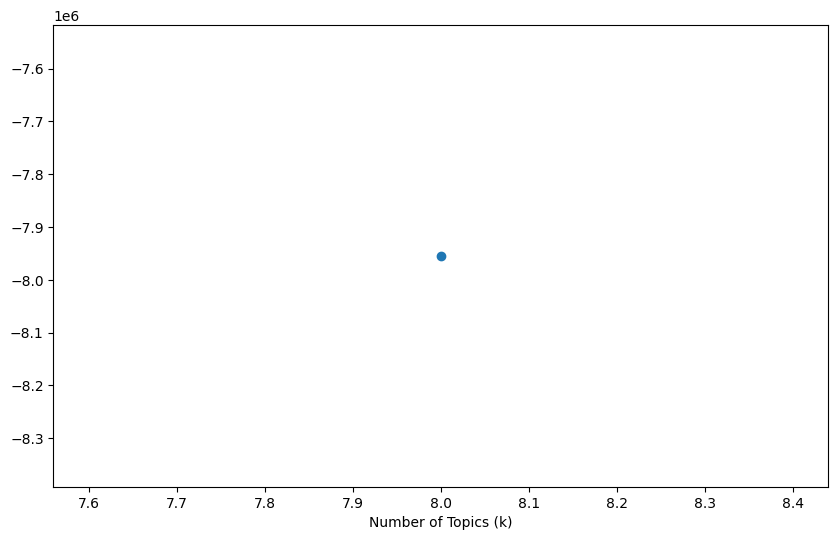

In [19]:
# plot scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(ks, scores, marker='o')
plt.xlabel('Number of Topics (k)')

In [21]:
# INSPECT LDA COMPONENTS
lda_components = lda.components_
lda_vocabulary = vocabulary

for index, component in enumerate(lda_components):
    zipped = zip(vocabulary, component)
    top_ngrams_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:10000]
    top_ngrams_list = list(dict(top_ngrams_key).keys())
    print("Topic " + str(index) + ": ", top_ngrams_list)

Topic 0:  ['get', 'hey', 'like', 'girl', 'ah', 'go', 'come', 'little', 'man', 'good', 'gonna', 'make', 'baby', 'look', 'boy', 'well', 'know', 'say', 'big', 'yeah', 'around', 'take', 'see', 'back', 'money', 'run', 'one', 'round', 'wanna', 'town', 'cause', 'way', 'hot', 'old', 'ya', 'put', 'right', 'work', 'new', 'want', 'time', 'tell', 'head', 'shake', 'woman', 'hand', 'love', 'car', 'keep', 'high', 'street', 'pretty', 'crazy', 'drive', 'honey', 'thing', 'let', 'mama', 'call', 'mi', 'turn', 'dem', 'bad', 'di', 'give', 'feel', 'sweet', 'party', 'daddy', 'walk', 'drink', 'city', 'day', 'jump', 'foot', 'every', 'door', 'yes', 'blue', 'buy', 'night', 'watch', 'stop', 'bang', 'kick', 'fun', 'two', 'need', 'start', 'dirty', 'red', 'lady', 'house', 'gun', 'move', 'bit', 'hair', 'dog', 'ride', 'home', 'wear', 'low', 'gotta', 'kid', 'cool', 'lot', 'hard', 'hear', 'hit', 'think', 'fine', 'boom', 'knock', 'long', 'floor', 'top', 'black', 'world', 'dress', 'talk', 'people', 'show', 'bar', 'em', 'fi

In [22]:
from helpers.GenreClassifierTrainer import GenreClassifierTrainer
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
print(X_train.shape)
print(X_test.shape)


(89957, 8)
(21981, 8)


In [23]:
# cat5
y_train_cat5 = corpus_train["cat5"]
y_test_cat5 = corpus_test["cat5"]

trainer5 = GenreClassifierTrainer(X_train=X_train, y_train=y_train_cat5, random_state=42)
trainer5.fit_with_fixed_params()

y_pred = trainer5.best_pipeline_.predict(X_test)
print(classification_report(y_test_cat5, y_pred))
print(f"f1_macro: {f1_score(y_test_cat5, y_pred,  average='macro'):.3f}")
print(f"Kappa: {cohen_kappa_score(y_test_cat5, y_pred):.3f}")

Training pipeline with fixed parameters...
              precision    recall  f1-score   support

  electronic       0.14      0.17      0.15      1952
     hip hop       0.49      0.83      0.62      1466
       metal       0.41      0.77      0.53      2167
         pop       0.36      0.51      0.42      4733
        rock       0.70      0.38      0.49     11663

    accuracy                           0.46     21981
   macro avg       0.42      0.53      0.44     21981
weighted avg       0.54      0.46      0.46     21981

f1_macro: 0.444
Kappa: 0.274


In [24]:
# cat12
y_train_cat12 = corpus_train["cat12"]
y_test_cat12 = corpus_test["cat12"]

trainer12 = GenreClassifierTrainer(X_train=X_train, y_train=y_train_cat12, random_state=42)
trainer12.fit_with_fixed_params()
y_pred = trainer12.best_pipeline_.predict(X_test)
print(classification_report(y_test_cat12, y_pred))
print(f"f1_macro: {f1_score(y_test_cat12, y_pred,  average='macro'):.3f}")
print(f"Kappa: {cohen_kappa_score(y_test_cat12, y_pred):.3f}")

Training pipeline with fixed parameters...
                  precision    recall  f1-score   support

alternative rock       0.07      0.05      0.06       952
      electronic       0.16      0.08      0.11      1991
       hard rock       0.06      0.17      0.09       708
     heavy metal       0.14      0.19      0.16      1261
         hip hop       0.51      0.82      0.63      1467
      indie rock       0.08      0.26      0.12       678
            jazz       0.05      0.38      0.08       383
           metal       0.48      0.64      0.55      2191
             pop       0.45      0.23      0.30      4556
        pop rock       0.02      0.25      0.05       257
            rock       0.60      0.08      0.14      7537

        accuracy                           0.24     21981
       macro avg       0.24      0.29      0.21     21981
    weighted avg       0.41      0.24      0.24     21981

f1_macro: 0.209
Kappa: 0.173


In [25]:
# cat25
y_train_cat25 = corpus_train["cat25"]
y_test_cat25 = corpus_test["cat25"]

trainer25 = GenreClassifierTrainer(
    X_train=X_train, y_train=y_train_cat25, random_state=42
)
trainer25.fit_with_fixed_params()
y_pred = trainer25.best_pipeline_.predict(X_test)
print(classification_report(y_test_cat25, y_pred))
print(f"f1_macro: {f1_score(y_test_cat25, y_pred,  average='macro'):.3f}")
print(f"Kappa: {cohen_kappa_score(y_test_cat25, y_pred):.3f}")

Training pipeline with fixed parameters...
                   precision    recall  f1-score   support

 alternative rock       0.03      0.00      0.01      1106
       blues rock       0.02      0.14      0.04       214
     classic rock       0.02      0.02      0.02       165
        classical       0.00      0.31      0.00        13
      death metal       0.17      0.75      0.28       302
       electronic       0.19      0.05      0.08      2034
             folk       0.04      0.32      0.07       172
        folk rock       0.05      0.12      0.07       239
        hard rock       0.08      0.09      0.09       744
      heavy metal       0.12      0.07      0.09       790
          hip hop       0.58      0.71      0.64      1475
       indie rock       0.08      0.08      0.08       682
             jazz       0.04      0.04      0.04       444
            metal       0.30      0.15      0.20      1965
              pop       0.16      0.00      0.00      3758
         pop

In [10]:
# Test with Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1, min_samples_leaf=30, n_estimators=250, max_features="sqrt", class_weight="balanced")
)

y_train_cat5 = corpus_train["cat5"]
y_test_cat5 = corpus_test["cat5"]
pipe.fit(X_train, y_train_cat5)
y_pred = pipe.predict(X_test)
print(classification_report(y_test_cat5, y_pred))
print(f"f1_macro: {f1_score(y_test_cat5, y_pred,  average='macro'):.3f}")
print(f"Kappa: {cohen_kappa_score(y_test_cat5, y_pred):.3f}")

              precision    recall  f1-score   support

  electronic       0.19      0.24      0.21      1952
     hip hop       0.57      0.85      0.68      1466
       metal       0.41      0.77      0.53      2167
         pop       0.38      0.50      0.43      4733
        rock       0.71      0.43      0.53     11663

    accuracy                           0.49     21981
   macro avg       0.45      0.56      0.48     21981
weighted avg       0.55      0.49      0.49     21981

f1_macro: 0.478
Kappa: 0.303


In [11]:
y_train_cat12 = corpus_train["cat12"]
y_test_cat12 = corpus_test["cat12"]
pipe.fit(X_train, y_train_cat12)
y_pred = pipe.predict(X_test)
print(classification_report(y_test_cat12, y_pred))
print(f"f1_macro: {f1_score(y_test_cat12, y_pred,  average='macro'):.3f}")
print(f"Kappa: {cohen_kappa_score(y_test_cat12, y_pred):.3f}")

                  precision    recall  f1-score   support

alternative rock       0.06      0.13      0.09       952
      electronic       0.23      0.15      0.18      1991
       hard rock       0.07      0.17      0.10       708
     heavy metal       0.16      0.25      0.19      1261
         hip hop       0.57      0.84      0.68      1467
      indie rock       0.06      0.20      0.09       678
            jazz       0.06      0.30      0.10       383
           metal       0.48      0.50      0.49      2191
             pop       0.42      0.31      0.36      4556
        pop rock       0.02      0.12      0.04       257
            rock       0.58      0.13      0.21      7537

        accuracy                           0.27     21981
       macro avg       0.25      0.28      0.23     21981
    weighted avg       0.41      0.27      0.28     21981

f1_macro: 0.230
Kappa: 0.188


In [12]:
y_train_cat25 = corpus_train["cat25"]
y_test_cat25 = corpus_test["cat25"]
pipe.fit(X_train, y_train_cat25)
y_pred = pipe.predict(X_test)
print(classification_report(y_test_cat25, y_pred))
print(f"f1_macro: {f1_score(y_test_cat25, y_pred,  average='macro'):.3f}")
print(f"Kappa: {cohen_kappa_score(y_test_cat25, y_pred):.3f}")

                   precision    recall  f1-score   support

 alternative rock       0.08      0.05      0.06      1106
       blues rock       0.02      0.07      0.03       214
     classic rock       0.02      0.06      0.02       165
        classical       0.00      0.15      0.01        13
      death metal       0.20      0.61      0.30       302
       electronic       0.28      0.08      0.12      2034
             folk       0.04      0.22      0.06       172
        folk rock       0.03      0.11      0.04       239
        hard rock       0.08      0.11      0.09       744
      heavy metal       0.10      0.06      0.07       790
          hip hop       0.63      0.80      0.71      1475
       indie rock       0.08      0.14      0.10       682
             jazz       0.06      0.13      0.08       444
            metal       0.35      0.17      0.23      1965
              pop       0.34      0.03      0.06      3758
         pop rock       0.02      0.08      0.03       

# CTM Test 
(deactivate prevalence through comment out)

In [ ]:
from helpers.STMTopicModeler import STMTopicModeler
from helpers.aggregate_artist_dtm import aggregate_dtm_by_artist

counts_train = monroe_extractor.transform(corpus_train["lyrics_lemmatized"])
vocabulary = monroe_extractor.vocabulary_
# genre here serves only for implemenation reasons
X_artist, _ = aggregate_dtm_by_artist(counts_train, corpus_train["track.s.firstartist.name"], corpus_train["cat5"])

stm = STMTopicModeler(
    k_range=(2,3), 
    random_state=42,
    model_dir="experiment_outputs/ctm_test" 
)
# again, genre was not used for computation of features
stm.tune_and_fit(X_artist, corpus_train["cat5"], vocab=vocabulary)

Converting data to STM format...
Tuning number of topics (K range: (2, 3))...
Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	..
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
.....................................................................................................
Completed E-Step (6 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -9.774) 
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -8.907, relative change = 8.864e-02) 
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 

Exception ignored from cffi callback <function _callback_wrapper_ABI.<locals>.outer_func at 0x0000016475579760>:
Traceback (most recent call last):
  File "N:\Materialien\Promotion\LyricsGenreRecognition\.venv\Lib\site-packages\rpy2\rinterface_lib\ffi_proxy.py", line 62, in outer_func
    def outer_func(*args, **kwargs):

KeyboardInterrupt: 


.......................................................................
Completed E-Step (4 seconds). 
Completed M-Step. 
Completing Iteration 115 (approx. per word bound = -8.803, relative change = 9.334e-05) 
Topic 1: come, time, know, never, take 
 Topic 2: love, go, oh, see, day 
 Topic 3: get, know, like, yeah, say 
.....................................................................................................
Completed E-Step (4 seconds). 
Completed M-Step. 
Completing Iteration 116 (approx. per word bound = -8.802, relative change = 9.212e-05) 
................................................................................

# STM Test mit 32 Genres als Genre Prevalence Covariate